In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS

# Load dataset
df = pd.read_csv(r'Instagram data.csv', encoding="latin1")

# Quick preview
print("Dataset Preview:")
display(df.head(5))
print('\nDataset shape:', df.shape)
print('\nData types:')
print(df.dtypes)

Dataset Preview:


,Impressions,From Home,From Hashtags,From Explore,From Other,Saves,Comments,Shares,Likes,Profile Visits,Follows,Caption,Hashtags,caption_length,hashtags_count,engagement
0,3920,2586,1028,619,56,98,9,5,162,35,2,Here are some of the most important data visua...,#financeÂ #moneyÂ #businessÂ #investingÂ #inve...,112,22,171
1,5394,2727,1838,1174,78,194,7,14,224,48,10,Here are some of the best data science project...,#healthcareÂ #healthÂ #covidÂ #dataÂ #datascie...,187,18,231
2,4021,2085,1188,0,533,41,11,1,131,62,12,Learn how to train a machine learning model an...,#dataÂ #datascienceÂ #dataanalysisÂ #dataanaly...,117,18,142
3,4528,2700,621,932,73,172,10,7,213,23,8,HereÂs how you can write a Python program to ...,#pythonÂ #pythonprogrammingÂ #pythonprojectsÂ ...,202,11,223
4,2518,1704,255,279,37,96,5,4,123,8,0,Plotting annotations while visualizing your da...,#datavisualizationÂ #datascienceÂ #dataÂ #data...,178,29,128



Dataset shape: (119, 16)

Data types:
Impressions        int64
From Home          int64
From Hashtags      int64
From Explore       int64
From Other         int64
Saves              int64
Comments           int64
Shares             int64
Likes              int64
Profile Visits     int64
Follows            int64
Caption           object
Hashtags          object
caption_length     int64
hashtags_count     int64
engagement         int64
dtype: object


In [2]:
# Data Cleaning & Transformation
# 1. Duplicates
dups = df.duplicated().sum()
print('Duplicate rows count:', dups)

# 2. Missing values per column
print('\nMissing values per column:')
print(df.isnull().sum())

# 3. Create helper columns
if 'Caption' in df.columns:
    df['caption_length'] = df['Caption'].astype(str).apply(len)
else:
    df['caption_length'] = np.nan

if 'Hashtags' in df.columns:
    def count_hashtags(x):
        s = str(x)
        return s.count('#') if '#' in s else len([t for t in s.replace(',',' ').split() if t.startswith('#')])
    df['hashtags_count'] = df['Hashtags'].astype(str).apply(count_hashtags)
else:
    df['hashtags_count'] = 0

# Engagement score
likes_col = next((c for c in df.columns if c.lower()=='likes'), None)
comments_col = next((c for c in df.columns if c.lower()=='comments'), None)
if likes_col and comments_col:
    df['engagement'] = pd.to_numeric(df[likes_col], errors='coerce').fillna(0) + pd.to_numeric(df[comments_col], errors='coerce').fillna(0)
else:
    df['engagement'] = np.nan

print('\nCreated columns: caption_length, hashtags_count, engagement')
print("\nData with new columns:")
display(df.head(3))

Duplicate rows count: 17

Missing values per column:
Impressions       0
From Home         0
From Hashtags     0
From Explore      0
From Other        0
Saves             0
Comments          0
Shares            0
Likes             0
Profile Visits    0
Follows           0
Caption           0
Hashtags          0
caption_length    0
hashtags_count    0
engagement        0
dtype: int64

Created columns: caption_length, hashtags_count, engagement

Data with new columns:


,Impressions,From Home,From Hashtags,From Explore,From Other,Saves,Comments,Shares,Likes,Profile Visits,Follows,Caption,Hashtags,caption_length,hashtags_count,engagement
0,3920,2586,1028,619,56,98,9,5,162,35,2,Here are some of the most important data visua...,#financeÂ #moneyÂ #businessÂ #investingÂ #inve...,112,22,171
1,5394,2727,1838,1174,78,194,7,14,224,48,10,Here are some of the best data science project...,#healthcareÂ #healthÂ #covidÂ #dataÂ #datascie...,187,18,231
2,4021,2085,1188,0,533,41,11,1,131,62,12,Learn how to train a machine learning model an...,#dataÂ #datascienceÂ #dataanalysisÂ #dataanaly...,117,18,142


In [3]:
# Engagement Statistics
likes_col = next((c for c in df.columns if c.lower()=='likes'), None)
comments_col = next((c for c in df.columns if c.lower()=='comments'), None)

if likes_col:
    likes = pd.to_numeric(df[likes_col], errors='coerce')
    print(f'Likes — mean: {likes.mean():.2f}, min: {likes.min():.0f}, max: {likes.max():.0f}')

if comments_col:
    comments = pd.to_numeric(df[comments_col], errors='coerce')
    print(f'Comments — mean: {comments.mean():.2f}, min: {comments.min():.0f}, max: {comments.max():.0f}')

if likes_col and comments_col:
    corr = pd.to_numeric(df[likes_col], errors='coerce').corr(pd.to_numeric(df[comments_col], errors='coerce'))
    print(f'\nCorrelation between likes and comments: {corr:.3f}')

print(f'\nCorrelation caption_length vs engagement: {df["caption_length"].corr(df["engagement"]):.3f}')
print(f'Correlation hashtags_count vs engagement: {df["hashtags_count"].corr(df["engagement"]):.3f}')

Likes — mean: 173.78, min: 72, max: 549
Comments — mean: 6.66, min: 0, max: 19

Correlation between likes and comments: 0.124

Correlation caption_length vs engagement: -0.149
Correlation hashtags_count vs engagement: -0.342


## Distribution of Key Metrics


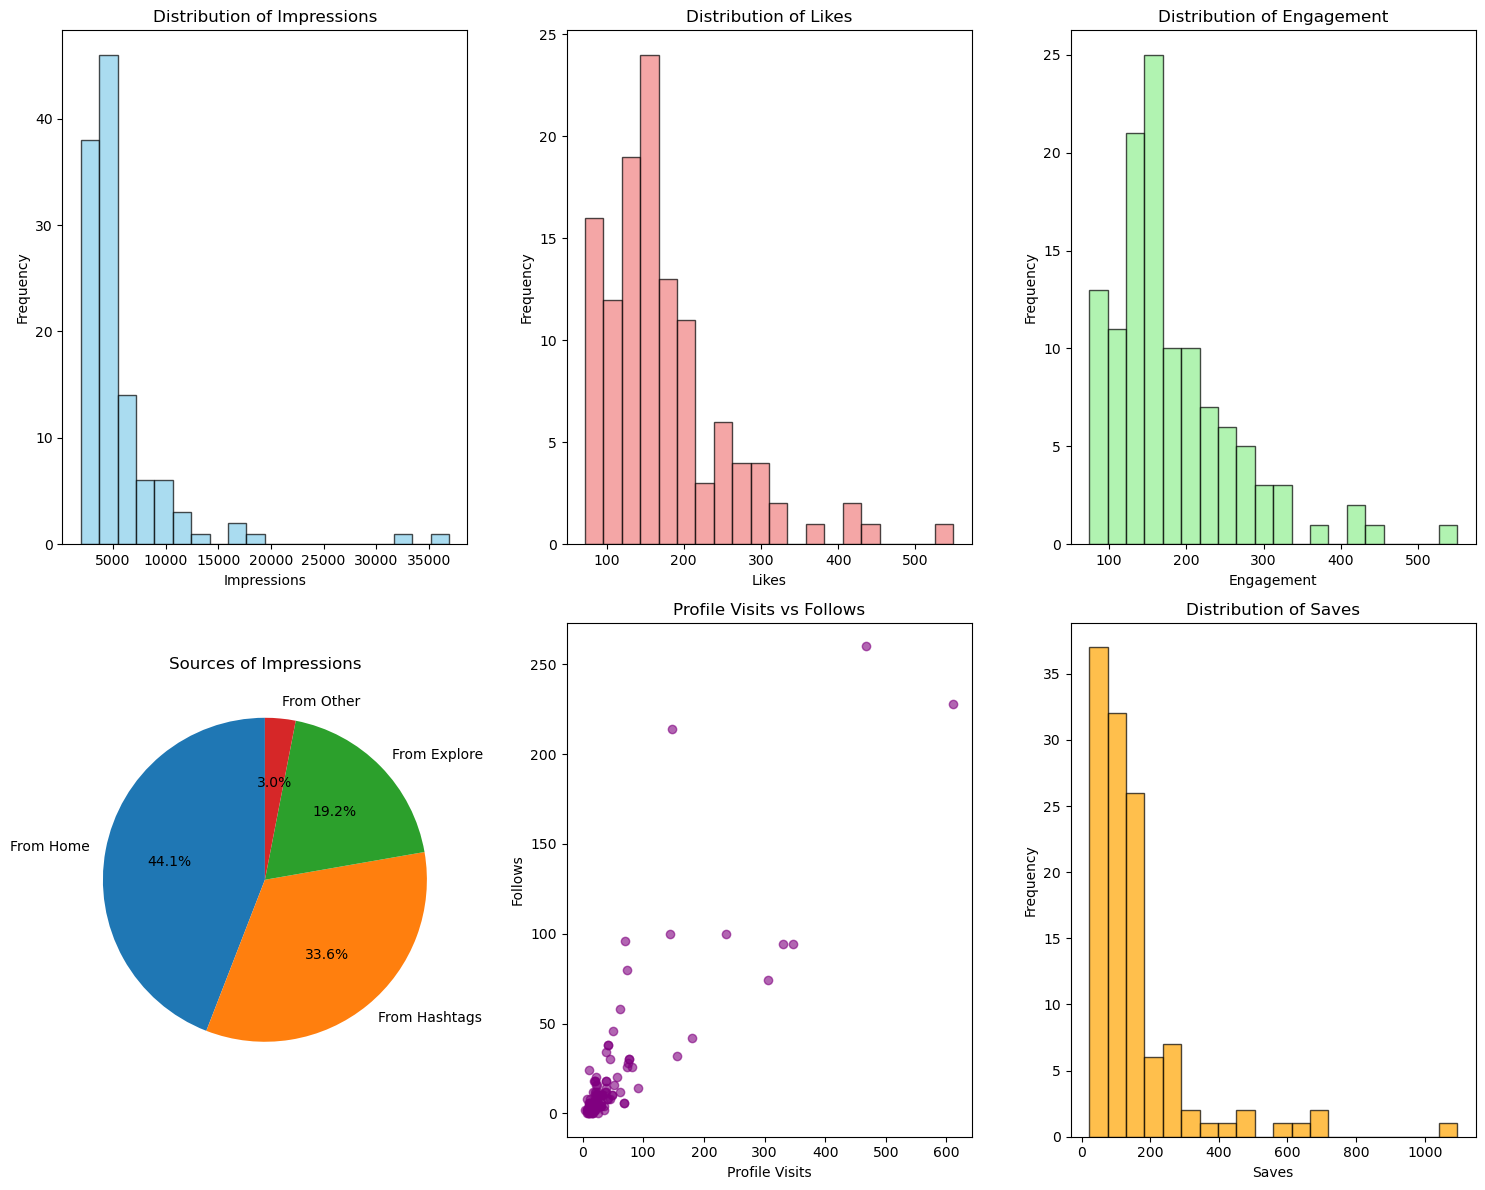

In [4]:
# Distribution Visualizations
print("## Distribution of Key Metrics")

plt.figure(figsize=(15, 12))

# Impressions distribution
plt.subplot(2, 3, 1)
plt.hist(df['Impressions'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Impressions')
plt.xlabel('Impressions')
plt.ylabel('Frequency')

# Likes distribution
plt.subplot(2, 3, 2)
plt.hist(df['Likes'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Distribution of Likes')
plt.xlabel('Likes')
plt.ylabel('Frequency')

# Engagement distribution
plt.subplot(2, 3, 3)
plt.hist(df['engagement'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Distribution of Engagement')
plt.xlabel('Engagement')
plt.ylabel('Frequency')

# Sources of Impressions
plt.subplot(2, 3, 4)
sources = ['From Home', 'From Hashtags', 'From Explore', 'From Other']
source_data = [df[col].sum() for col in sources]
plt.pie(source_data, labels=sources, autopct='%1.1f%%', startangle=90)
plt.title('Sources of Impressions')

# Profile Visits vs Follows
plt.subplot(2, 3, 5)
plt.scatter(df['Profile Visits'], df['Follows'], alpha=0.6, color='purple')
plt.title('Profile Visits vs Follows')
plt.xlabel('Profile Visits')
plt.ylabel('Follows')

# Saves distribution
plt.subplot(2, 3, 6)
plt.hist(df['Saves'], bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.title('Distribution of Saves')
plt.xlabel('Saves')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Correlation Matrix Analysis


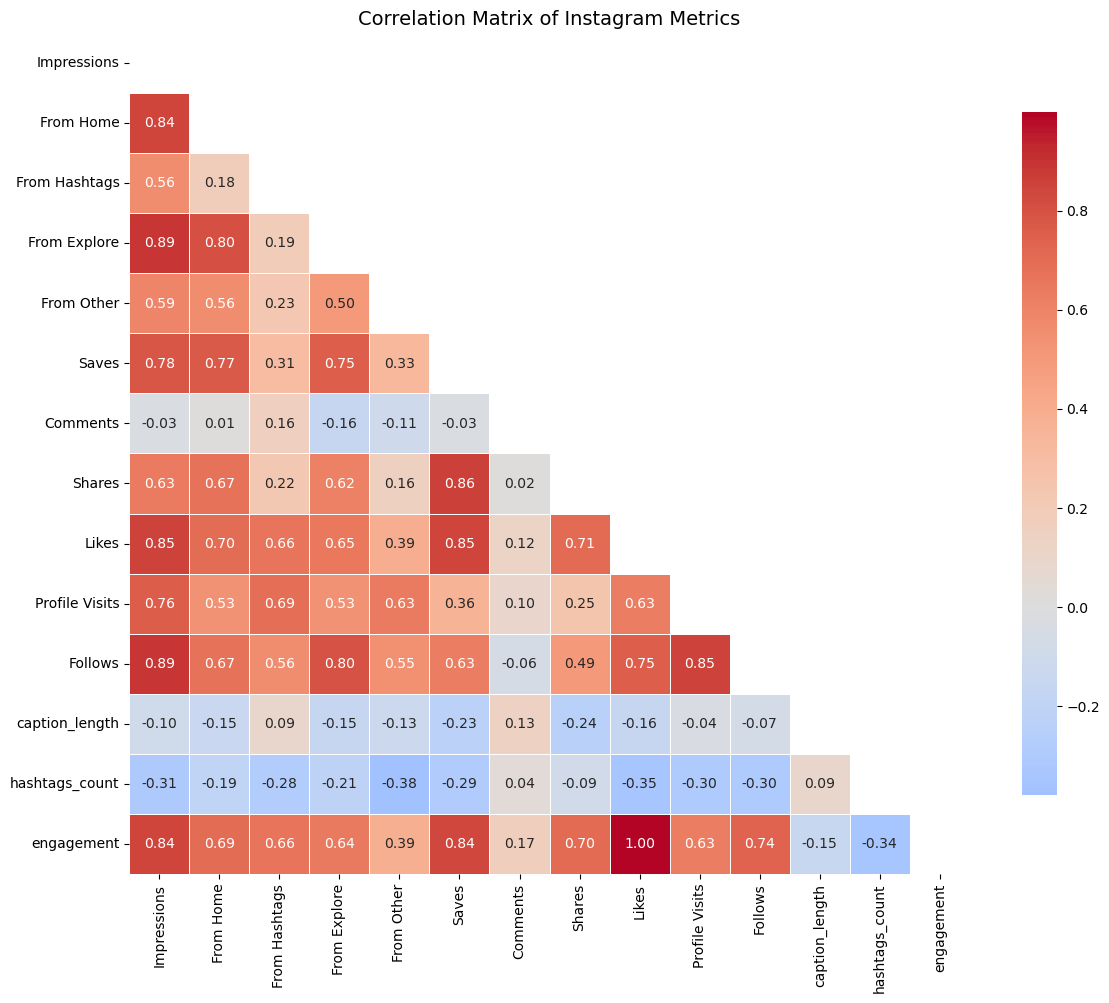


Key Correlations:
Engagement vs Likes: 0.999
Engagement vs Impressions: 0.843
Engagement vs Profile Visits: 0.626
Impressions vs From Home: 0.845


In [5]:
# Correlation Analysis
print("## Correlation Matrix Analysis")

plt.figure(figsize=(12, 10))
numeric_cols = ['Impressions', 'From Home', 'From Hashtags', 'From Explore', 'From Other', 
                'Saves', 'Comments', 'Shares', 'Likes', 'Profile Visits', 'Follows', 
                'caption_length', 'hashtags_count', 'engagement']

correlation_matrix = df[numeric_cols].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Correlation Matrix of Instagram Metrics', fontsize=14)
plt.tight_layout()
plt.show()

# Print key correlations
print("\nKey Correlations:")
print(f"Engagement vs Likes: {df['engagement'].corr(df['Likes']):.3f}")
print(f"Engagement vs Impressions: {df['engagement'].corr(df['Impressions']):.3f}")
print(f"Engagement vs Profile Visits: {df['engagement'].corr(df['Profile Visits']):.3f}")
print(f"Impressions vs From Home: {df['Impressions'].corr(df['From Home']):.3f}")

## Engagement vs Content Features Analysis


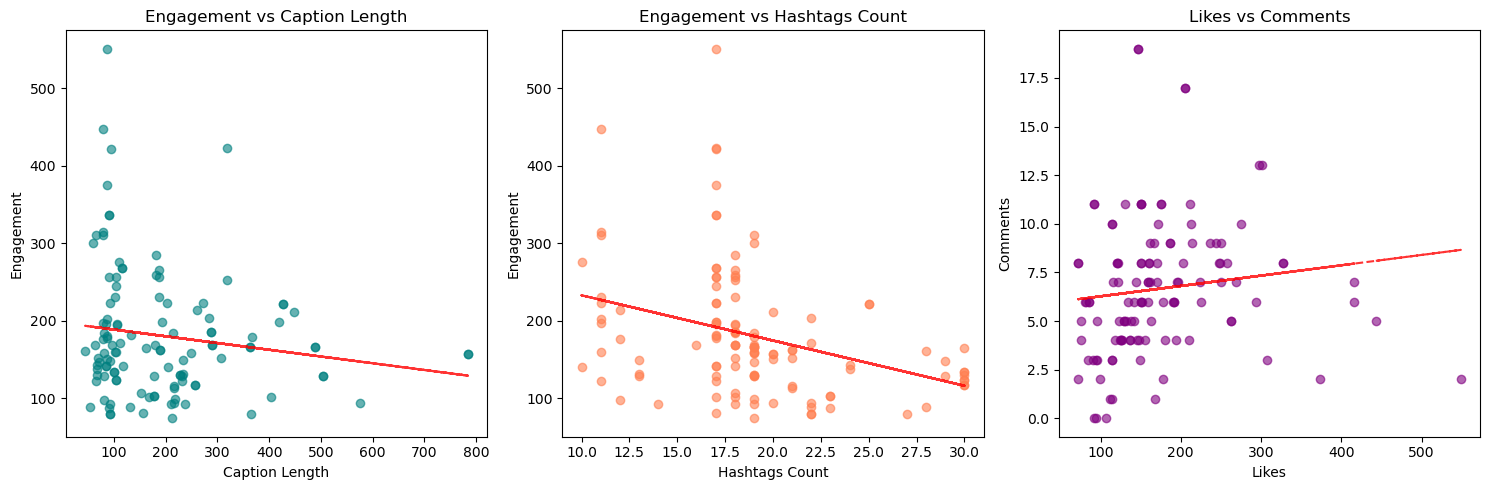

In [6]:
# Engagement vs Content Features
print("## Engagement vs Content Features Analysis")

plt.figure(figsize=(15, 5))

# Engagement vs Caption Length
plt.subplot(1, 3, 1)
plt.scatter(df['caption_length'], df['engagement'], alpha=0.6, color='teal')
plt.xlabel('Caption Length')
plt.ylabel('Engagement')
plt.title('Engagement vs Caption Length')
z = np.polyfit(df['caption_length'], df['engagement'], 1)
p = np.poly1d(z)
plt.plot(df['caption_length'], p(df['caption_length']), "r--", alpha=0.8)

# Engagement vs Hashtags Count
plt.subplot(1, 3, 2)
plt.scatter(df['hashtags_count'], df['engagement'], alpha=0.6, color='coral')
plt.xlabel('Hashtags Count')
plt.ylabel('Engagement')
plt.title('Engagement vs Hashtags Count')
z = np.polyfit(df['hashtags_count'], df['engagement'], 1)
p = np.poly1d(z)
plt.plot(df['hashtags_count'], p(df['hashtags_count']), "r--", alpha=0.8)

# Likes vs Comments
plt.subplot(1, 3, 3)
plt.scatter(df['Likes'], df['Comments'], alpha=0.6, color='purple')
plt.xlabel('Likes')
plt.ylabel('Comments')
plt.title('Likes vs Comments')
z = np.polyfit(df['Likes'], df['Comments'], 1)
p = np.poly1d(z)
plt.plot(df['Likes'], p(df['Likes']), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

## Performance by Traffic Source


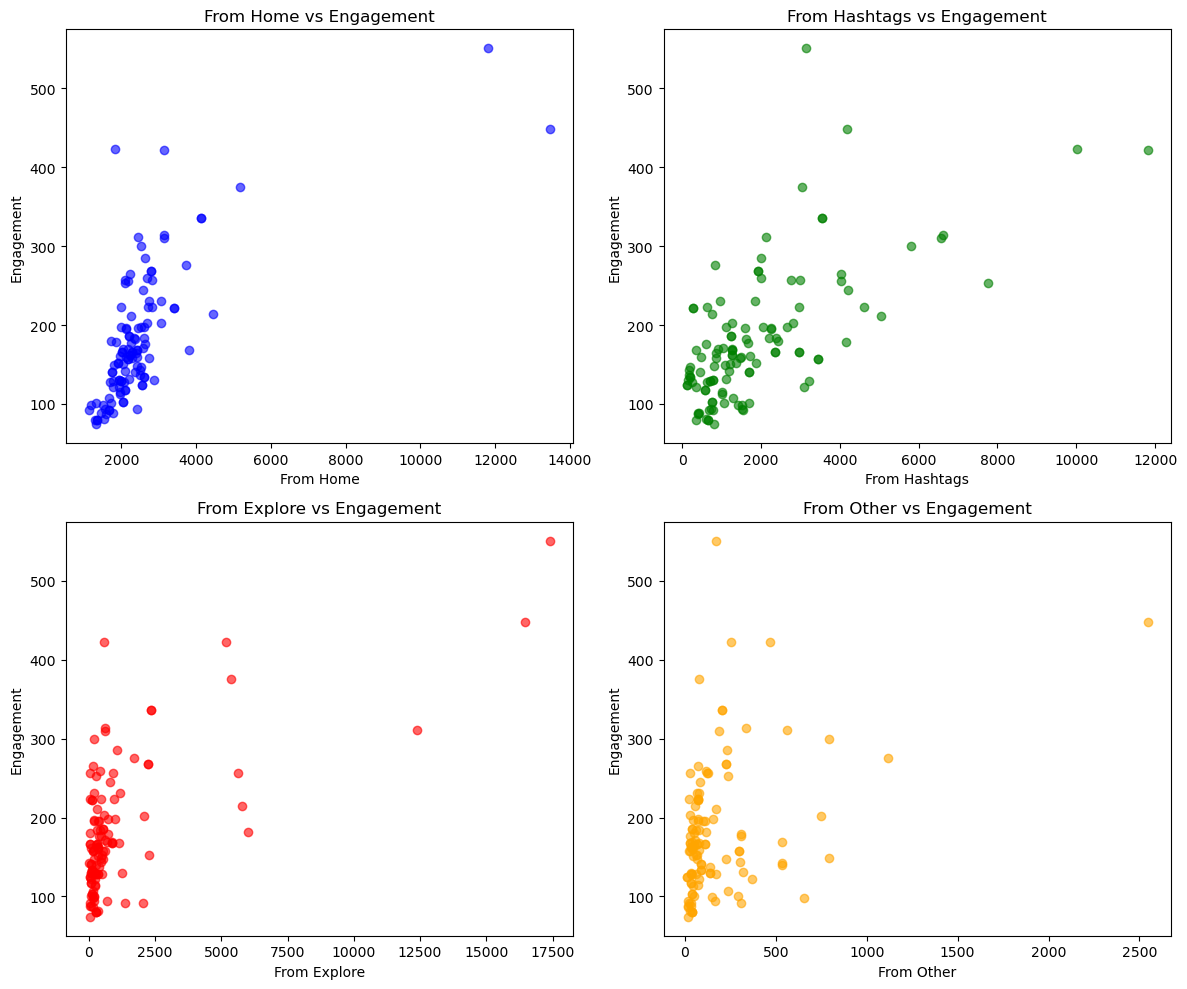

In [7]:
# Performance by Traffic Source
print("## Performance by Traffic Source")

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.scatter(df['From Home'], df['engagement'], alpha=0.6, color='blue')
plt.xlabel('From Home')
plt.ylabel('Engagement')
plt.title('From Home vs Engagement')

plt.subplot(2, 2, 2)
plt.scatter(df['From Hashtags'], df['engagement'], alpha=0.6, color='green')
plt.xlabel('From Hashtags')
plt.ylabel('Engagement')
plt.title('From Hashtags vs Engagement')

plt.subplot(2, 2, 3)
plt.scatter(df['From Explore'], df['engagement'], alpha=0.6, color='red')
plt.xlabel('From Explore')
plt.ylabel('Engagement')
plt.title('From Explore vs Engagement')

plt.subplot(2, 2, 4)
plt.scatter(df['From Other'], df['engagement'], alpha=0.6, color='orange')
plt.xlabel('From Other')
plt.ylabel('Engagement')
plt.title('From Other vs Engagement')

plt.tight_layout()
plt.show()

## Trend Analysis by Post Order


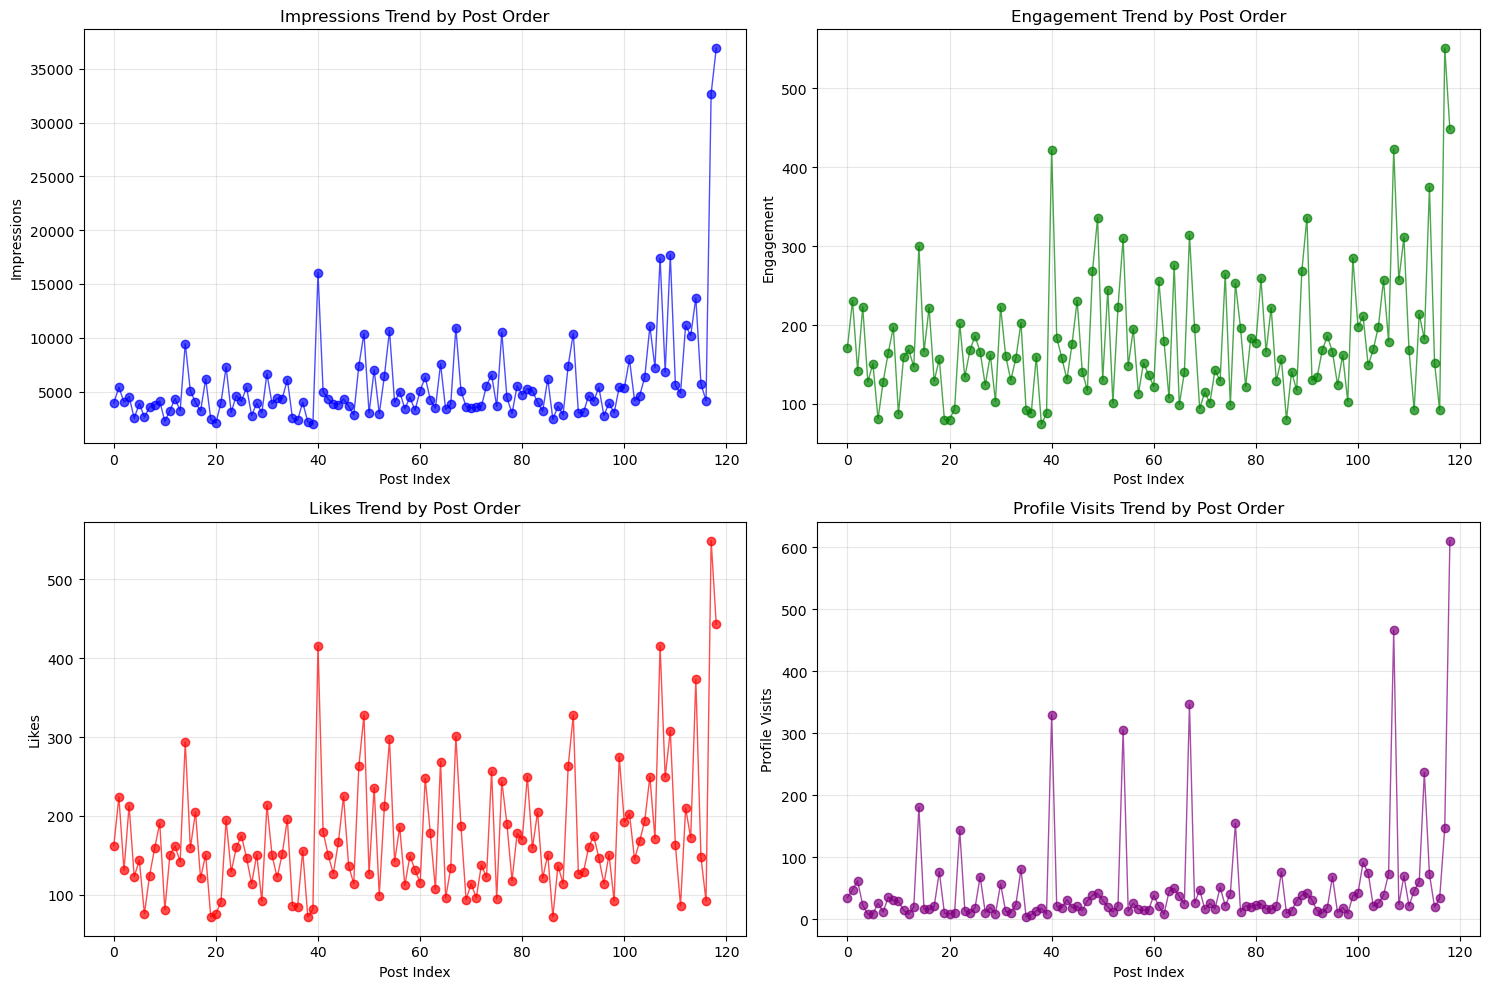

In [8]:
# Trend Analysis
print("## Trend Analysis by Post Order")

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(df.index, df['Impressions'], marker='o', alpha=0.7, color='blue', linewidth=1)
plt.title('Impressions Trend by Post Order')
plt.xlabel('Post Index')
plt.ylabel('Impressions')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(df.index, df['engagement'], marker='o', alpha=0.7, color='green', linewidth=1)
plt.title('Engagement Trend by Post Order')
plt.xlabel('Post Index')
plt.ylabel('Engagement')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(df.index, df['Likes'], marker='o', alpha=0.7, color='red', linewidth=1)
plt.title('Likes Trend by Post Order')
plt.xlabel('Post Index')
plt.ylabel('Likes')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(df.index, df['Profile Visits'], marker='o', alpha=0.7, color='purple', linewidth=1)
plt.title('Profile Visits Trend by Post Order')
plt.xlabel('Post Index')
plt.ylabel('Profile Visits')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conversion Rates Analysis


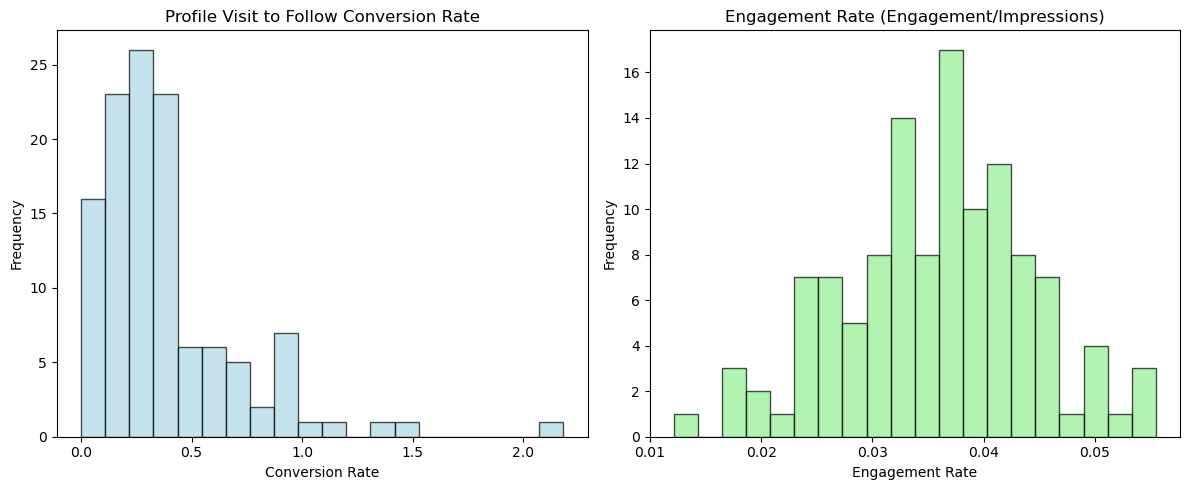

Average Visit-to-Follow Conversion Rate: 0.382
Average Engagement Rate: 0.036


In [9]:
# Conversion Rates Analysis
print("## Conversion Rates Analysis")

# Calculate conversion rates
df['visit_to_follow_rate'] = df['Follows'] / df['Profile Visits'].replace(0, np.nan)
df['engagement_rate'] = df['engagement'] / df['Impressions'].replace(0, np.nan)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['visit_to_follow_rate'].dropna(), bins=20, alpha=0.7, color='lightblue', edgecolor='black')
plt.title('Profile Visit to Follow Conversion Rate')
plt.xlabel('Conversion Rate')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['engagement_rate'].dropna(), bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Engagement Rate (Engagement/Impressions)')
plt.xlabel('Engagement Rate')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Average Visit-to-Follow Conversion Rate: {df['visit_to_follow_rate'].mean():.3f}")
print(f"Average Engagement Rate: {df['engagement_rate'].mean():.3f}")

## Top Performing Posts Analysis


<Figure size 1200x600 with 0 Axes>

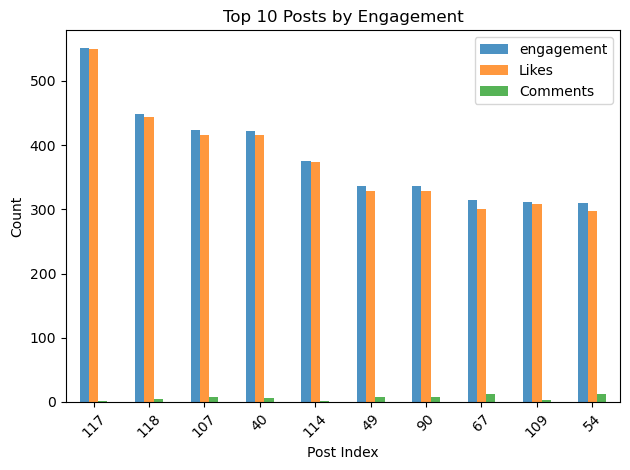

Summary statistics for top 10 engaging posts:
       engagement       Likes   Comments   Impressions  caption_length  \
count   10.000000   10.000000  10.000000     10.000000       10.000000   
mean   382.600000  375.900000   6.700000  17685.700000      107.200000   
std     78.403798   80.777403   4.001389   9517.458462       74.542754   
min    310.000000  297.000000   2.000000  10386.000000       66.000000   
25%    319.500000  313.000000   3.500000  10733.500000       79.000000   
50%    355.500000  350.500000   6.500000  14881.000000       87.000000   
75%    422.750000  416.000000   8.000000  17633.750000       91.000000   
max    551.000000  549.000000  13.000000  36919.000000      318.000000   

       hashtags_count  
count       10.000000  
mean        15.400000  
std          3.098387  
min         11.000000  
25%         12.500000  
50%         17.000000  
75%         17.000000  
max         19.000000  


In [10]:
# Top Performing Posts Analysis
print("## Top Performing Posts Analysis")

top_10_engagement = df.nlargest(10, 'engagement')[['engagement', 'Likes', 'Comments', 'Impressions', 'caption_length', 'hashtags_count']]

plt.figure(figsize=(12, 6))
top_10_engagement[['engagement', 'Likes', 'Comments']].plot(kind='bar', alpha=0.8)
plt.title('Top 10 Posts by Engagement')
plt.xlabel('Post Index')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("Summary statistics for top 10 engaging posts:")
print(top_10_engagement.describe())

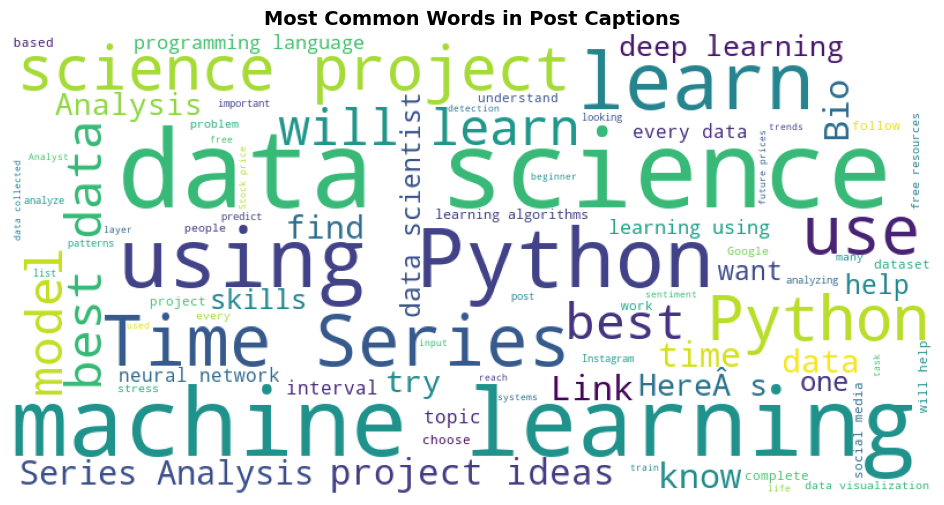

Word cloud showing most frequent words in post captions


In [11]:
#Word Analysis
# Combine all captions
all_text = ' '.join(df['Caption'].astype(str))

# Create WordCloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    max_words=80
).generate(all_text)

# Display it
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Common Words in Post Captions', fontsize=14, fontweight='bold')
plt.show()

print("Word cloud showing most frequent words in post captions")

## Conclusions

### **Key Conclusions**

1. **Content quality indicators outperform basic interaction metrics**  
   Posts that generate higher numbers of *Saves* and *Shares* consistently show stronger overall performance. These actions represent deeper user interest, and Instagram’s algorithm responds by pushing such posts to a wider audience, increasing impressions and reach.

2. **Non-follower reach is the strongest driver of growth**  
   Posts discovered through sources like *Explore* and other non-follower entry points demonstrate the highest reach expansion. This indicates that discoverability-oriented content (educational, shareable, or trend-aligned) is the real engine of audience growth.

3. **Hashtag effectiveness follows a diminishing-returns pattern**  
   Using too many hashtags does not improve visibility. Moderate, relevant hashtag usage performs better than long or unfocused hashtag lists, suggesting that quality and relevance matter more than quantity.

4. **Caption length influences user behavior more than visibility**  
   Short to medium-length captions lead to better engagement (comments, saves) as users can consume the content quickly. Extremely long captions show reduced interaction rates and may discourage user engagement.

---

---
**Course:** EraaSoft
**Instructor:** Special thanks to Sayed Abdul-Monem for emphasizing curiosity, critical thinking, and storytelling in data analysis.
